In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.metrics import MetricFrame

In [2]:
# Ignoring warnings (many warnings come from the FairLearn package)
import warnings
warnings.filterwarnings('ignore')

#### Reading in the data and getting an overview

In [3]:
# Starting with 35k observations that have NA values filled from KNN imputation
df = pd.read_csv('na_filled_df.csv').sample(n=35000, random_state=2025)
print(df.shape)
print(df.columns)

(35000, 21)
Index(['action_taken', 'preapproval', 'property_value', 'loan_purpose',
       'lien_status', 'reverse_mortgage', 'open-end_line_of_credit',
       'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
       'loan_term', 'negative_amortization', 'occupancy_type', 'income',
       'debt_to_income_ratio', 'applicant_sex', 'conforming_loan_limit',
       'derived_loan_product_type', 'derived_dwelling_category',
       'derived_race', 'applicant_age_above_62'],
      dtype='object')


****

### Formatting the data

In [4]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)

In [5]:
# Correlation remover can only use numeric data, so only selecting numeric data and sensitive features
numeric_columns = ['loan_amount', 'loan_to_value_ratio', 'loan_term', 'income', 'debt_to_income_ratio' ]
sensitive_features = ['applicant_sex', 'derived_race', 'applicant_age_above_62']
df0 = df.copy()[numeric_columns+sensitive_features] # This is the numeric data along with the sensitive features that will be preprocesed
df1 = df.copy().drop(columns=numeric_columns) # This is the rest of the data that will be merged back onto after preprocessing

In [6]:
# Creating a data frame with the dummies of the sensitive features
df_dummies = pd.get_dummies(df0, columns=sensitive_features, drop_first=False)

## Pre processing the data

In [7]:
# Update the sensitive feature list to match the one-hot encoded column names
sensitive_features_dummies = [col for col in df_dummies.columns if 'applicant_sex' in col or 'applicant_age_above_62' in col or 'derived_race' in col]

# Initialize the CorrelationRemover
cr = CorrelationRemover(sensitive_feature_ids=sensitive_features_dummies, alpha=1)

# Fit and transform the data
transformed_data = cr.fit_transform(df_dummies)

# Create a new DataFrame with the transformed data and the same column names
transformed_df = pd.DataFrame(transformed_data, columns=[col for col in df_dummies.columns if col not in sensitive_features_dummies], index=df_dummies.index)

In [8]:
# Merging the transformed numeric data back together with the string data
final_df = pd.concat([transformed_df, df1], axis=1)

In [9]:
# One hot encoding the transformed data and the original data
final_df_dummies = pd.get_dummies(final_df, columns=['applicant_sex', 'applicant_age_above_62', 'derived_race'], drop_first=True)

df_dummies = pd.get_dummies(df, columns=['applicant_sex', 'applicant_age_above_62', 'derived_race'], drop_first=True)

## Comparing new correlations to old correlations

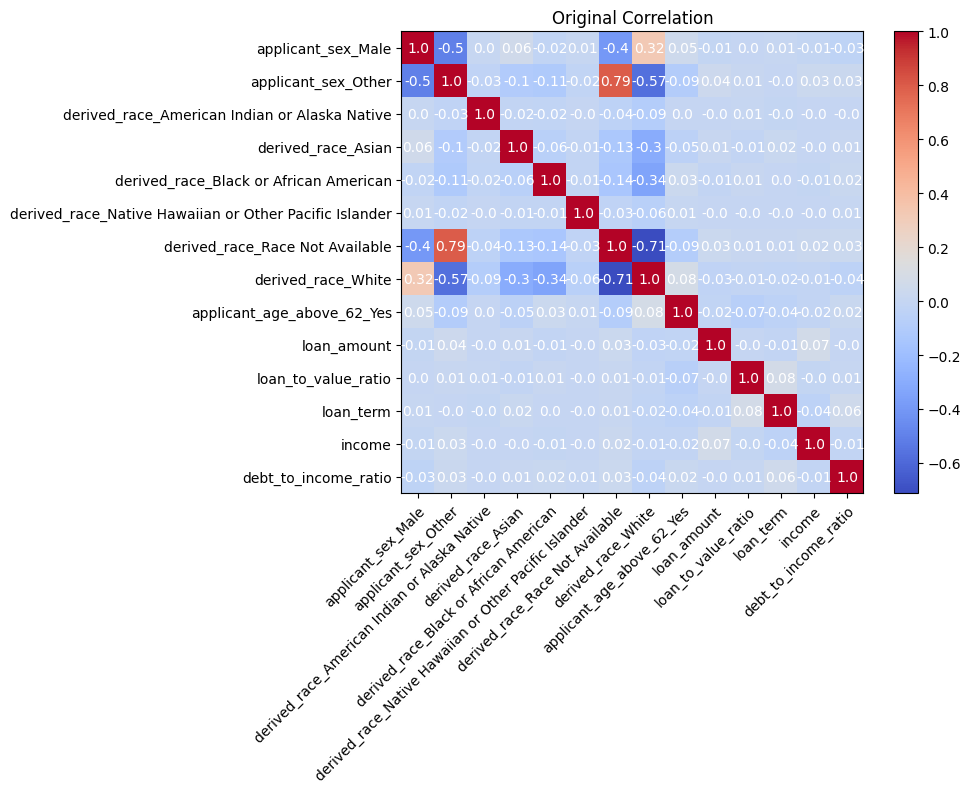

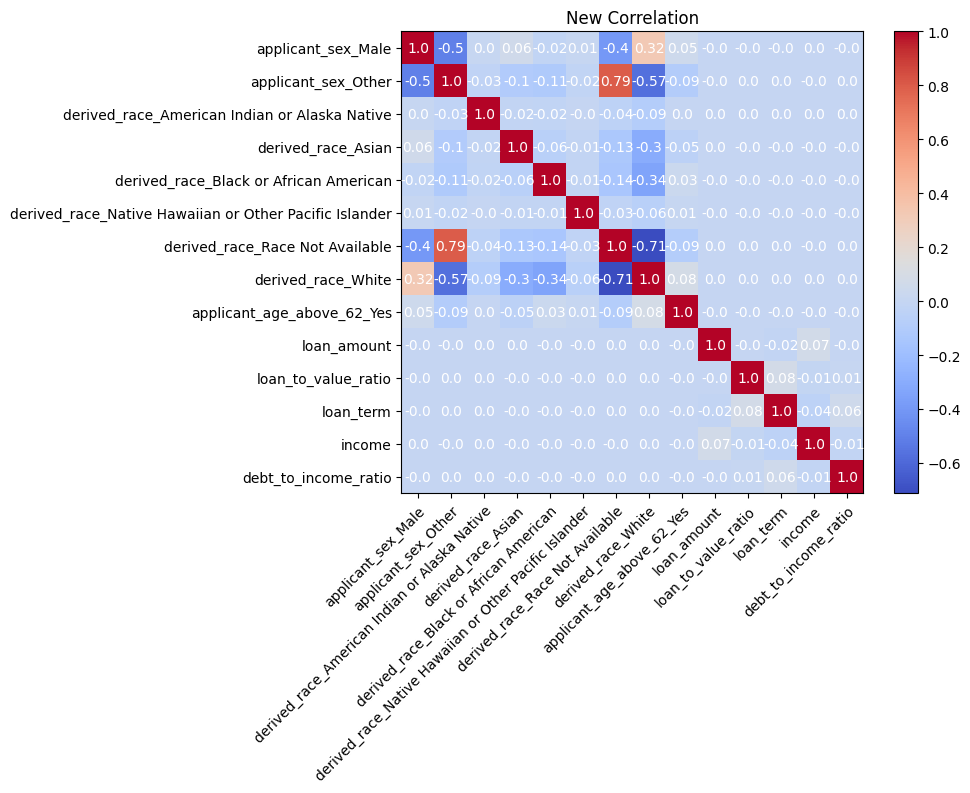

In [10]:
def plot_heatmap(df, title, features):
    # Ensure the features list only contains columns present in the DataFrame
    valid_features = [feature for feature in features if feature in df.columns]

    # Creating a smaller DataFrame with the selected columns
    smaller_df = df[valid_features]

    # Compute correlation
    corr_matrix = smaller_df.corr()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(corr_matrix, cmap="coolwarm")
    ax.set_xticks(np.arange(len(smaller_df.columns)))
    ax.set_xticklabels(smaller_df.columns)
    ax.set_yticks(np.arange(len(smaller_df.columns)))
    ax.set_yticklabels(smaller_df.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(smaller_df.columns)):
        for j in range(len(smaller_df.columns)):
            ax.text(j, i, round(corr_matrix.to_numpy()[i, j], 2), ha="center", va="center", color="w")

    ax.set_title(f"{title}")
    fig.colorbar(cax)
    plt.show()

# Testing the function
features_to_plot = sensitive_features_dummies+numeric_columns
plot_heatmap(df_dummies, "Original Correlation", features_to_plot)
plot_heatmap(final_df_dummies, "New Correlation", features_to_plot)

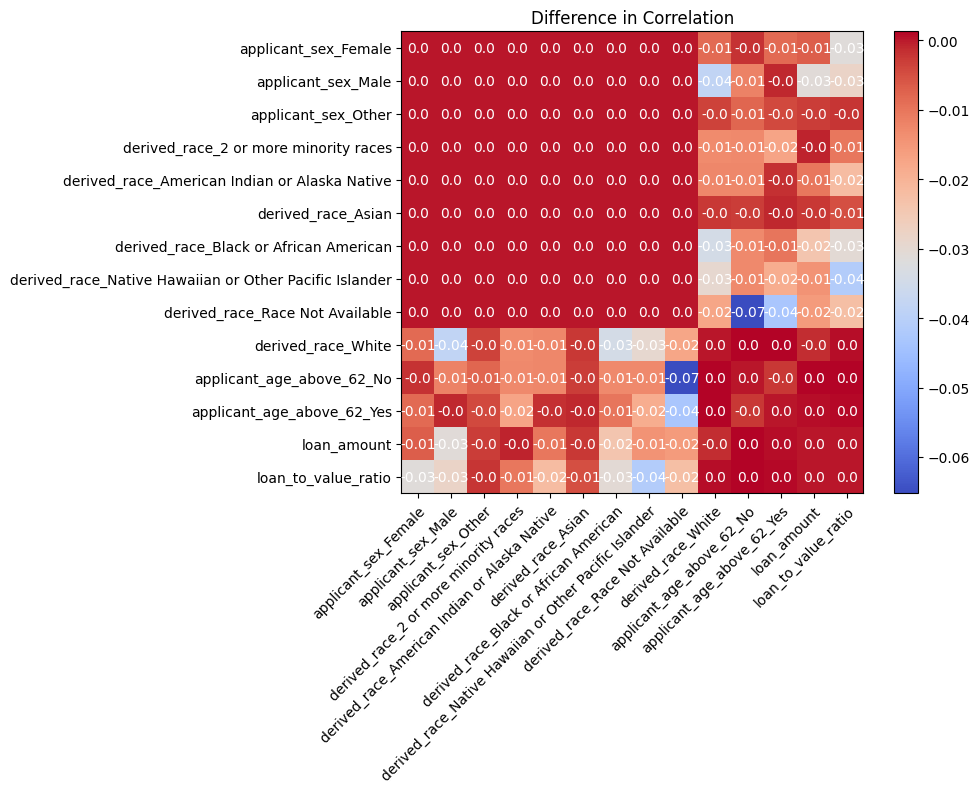

In [11]:
def get_corr_matrix(df, features):
    valid_features = [feature for feature in features if feature in df.columns]
    smaller_df = df[valid_features]
    return smaller_df.corr()

def plot_heatmap_difference(df1, df2, features, title):
    # Get the correlation matrices for each DataFrame
    corr_matrix_1 = get_corr_matrix(df1, features)
    corr_matrix_2 = get_corr_matrix(df2, features)

    # Calculate the difference
    abs_corr_matrix_1 = abs(corr_matrix_1)
    abs_corr_matrix_2 = abs(corr_matrix_2)
    diff_corr_matrix = abs_corr_matrix_2 - abs_corr_matrix_1

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(diff_corr_matrix, cmap="coolwarm")
    
    # Use the actual number of columns in the correlation matrix
    num_features = diff_corr_matrix.shape[0]

    ax.set_xticks(np.arange(num_features))
    ax.set_xticklabels(features[:num_features])  # Truncate labels if necessary
    ax.set_yticks(np.arange(num_features))
    ax.set_yticklabels(features[:num_features])  # Truncate labels if necessary
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(num_features):
        for j in range(num_features):
            ax.text(j, i, round(diff_corr_matrix.to_numpy()[i, j], 2), ha="center", va="center", color="w")

    ax.set_title(f"{title}")
    fig.colorbar(cax)
    plt.show()

features_to_plot = sensitive_features_dummies+numeric_columns
plot_heatmap_difference(df_dummies, final_df_dummies, features_to_plot, "Difference in Correlation")

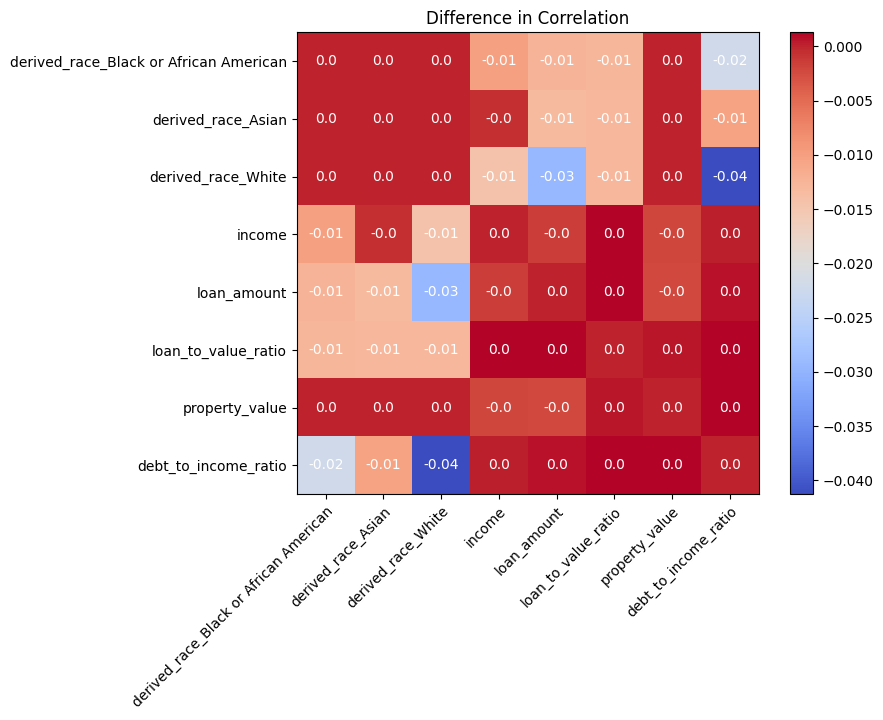

In [12]:
# Alternatively, you can make the plot smaller by looking at a subset of features
features_to_plot = ['derived_race_Black or African American', 'derived_race_Asian', 'derived_race_White',
       'income','loan_amount', 'loan_to_value_ratio', 'property_value', 'debt_to_income_ratio'] 
plot_heatmap_difference(df_dummies, final_df_dummies, features_to_plot, "Difference in Correlation")

In [13]:
# Returning the largest differences between the preprocessed data and original data correlations
features_to_plot = sensitive_features_dummies+numeric_columns

matrix_1 = get_corr_matrix(df_dummies, features_to_plot)
matrix_2 = get_corr_matrix(final_df_dummies, features_to_plot)
# Calculate the difference
abs_matrix_1 = abs(matrix_1)
abs_matrix_2 = abs(matrix_2)
diff_matrix = -(abs_matrix_1 - abs_matrix_2)


def find_top_correlations(corr_matrix):
    # Flatten the correlation matrix and reset index
    corr_flat = corr_matrix.unstack().reset_index()
    corr_flat.columns = ['Feature1', 'Feature2', 'Correlation']

    # Remove self-correlations
    corr_flat = corr_flat[corr_flat['Feature1'] != corr_flat['Feature2']]

    # Find top 10 positive correlations
    top_positive = corr_flat[corr_flat['Correlation'] > 0].sort_values(by='Correlation', ascending=False) # Use .head() for smaller list

    # Find top 10 negative correlations
    top_negative = corr_flat[corr_flat['Correlation'] < 0].sort_values(by='Correlation') # Use .head() for smaller list

    return top_positive, top_negative

greatest_addition, greatest_reduction = find_top_correlations(diff_matrix)

In [14]:
# The correlations most increased by the preprocessing algorithm (bad)
greatest_addition

,Feature1,Feature2,Correlation
153,loan_to_value_ratio,debt_to_income_ratio,0.001299
192,debt_to_income_ratio,loan_to_value_ratio,0.001299
152,loan_to_value_ratio,income,0.001171
178,income,loan_to_value_ratio,0.001171
136,loan_amount,loan_to_value_ratio,0.001165
149,loan_to_value_ratio,loan_amount,0.001165
137,loan_amount,loan_term,0.001115
163,loan_term,loan_amount,0.001115
167,loan_term,debt_to_income_ratio,0.000811
193,debt_to_income_ratio,loan_term,0.000811


In [15]:
# The correlations most decreased by the preprocessing algorithm (good)
greatest_reduction

,Feature1,Feature2,Correlation
148,loan_to_value_ratio,applicant_age_above_62_Yes,-0.065244
122,applicant_age_above_62_Yes,loan_to_value_ratio,-0.065244
123,applicant_age_above_62_Yes,loan_term,-0.043137
162,loan_term,applicant_age_above_62_Yes,-0.043137
111,derived_race_White,debt_to_income_ratio,-0.041292
...,...,...,...
159,loan_term,derived_race_Native Hawaiian or Other Pacific ...,-0.000952
25,applicant_sex_Other,loan_term,-0.000841
155,loan_term,applicant_sex_Other,-0.000841
54,derived_race_Asian,income,-0.000567


****

## Building a random forest model

In [16]:
# Create dummy variables for the random forest model
string_columns = final_df.select_dtypes(include=['object']).columns
df_dummies = pd.get_dummies(final_df, columns=string_columns, drop_first=True)

In [17]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
X = X.drop(columns=[col for col in df_dummies.columns if 'applicant_sex' in col or 'applicant_age_above_62' in col or 'derived_race' in col])
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

In [18]:
# Building the random forest model
np.random.seed(2023)
rf0 = RandomForestClassifier(n_estimators=100, random_state=2023)
rf0.fit(X_train, y_train)

# Generating predictions and displaying the confusion matrix
y_pred = rf0.predict(X_test)

In [19]:
# Manually defining some metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

Accuracy: 0.7538
Precision: 0.7699
Recall: 0.9115
F1 Score: 0.8347
False positive rate: 0.5843
False negative rate: 0.0885
Selection rate: 0.8074
Count: 8750.0000
Confusion Matrix:


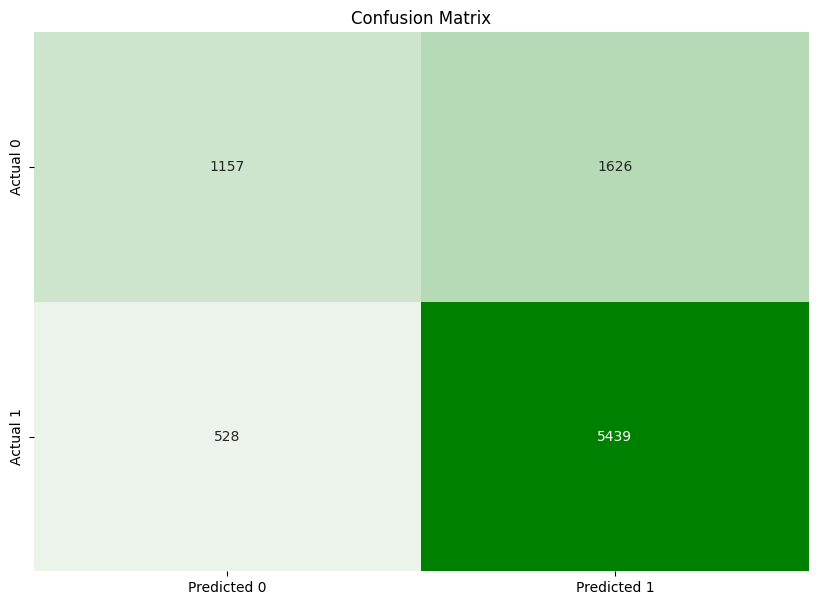

In [20]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)
fnr =  false_negative_rate(y_test, y_pred)
sr = selection_rate(y_test, y_pred)
total = count(y_test, y_pred)

# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False positive rate: {fpr:.4f}")
print(f"False negative rate: {fnr:.4f}")
print(f"Selection rate: {sr:.4f}")
print(f"Count: {total:.4f}")


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

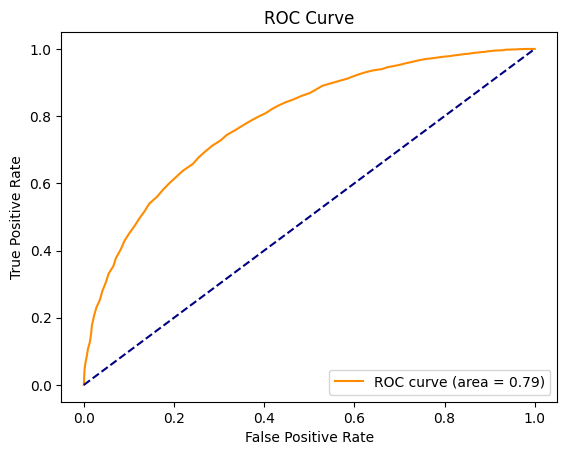

In [21]:
# Plotting the ROC curve
y_prob = rf0.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  

In [22]:
importances = rf0.feature_importances_.round(3)
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [X.columns[idx] for idx in sorted_indices]

sorted_features_with_importance = []
for i, idx in enumerate(sorted_indices):
    feature_name = X.columns[idx]
    importance_value = importances[idx]
    print(f"{i + 1}. {feature_name} ({importance_value})")
    sorted_features_with_importance.append((feature_name, importance_value))

1. loan_to_value_ratio (0.18)
2. income (0.157)
3. property_value (0.144)
4. debt_to_income_ratio (0.14)
5. loan_amount (0.137)
6. loan_term (0.097)
7. loan_purpose (0.052)
8. derived_loan_product_type_FHA:First Lien (0.013)
9. derived_loan_product_type_VA:First Lien (0.012)
10. open-end_line_of_credit (0.011)
11. occupancy_type (0.011)
12. derived_dwelling_category_Single Family (1-4 Units):Site-Built (0.007)
13. derived_dwelling_category_Single Family (1-4 Units):Manufactured (0.007)
14. business_or_commercial_purpose (0.006)
15. lien_status (0.005)
16. preapproval (0.005)
17. derived_loan_product_type_Conventional:Subordinate Lien (0.004)
18. reverse_mortgage (0.003)
19. negative_amortization (0.003)
20. conforming_loan_limit_NC (0.003)
21. derived_loan_product_type_FSA/RHS:First Lien (0.002)
22. conforming_loan_limit_U (0.001)
23. derived_loan_product_type_FHA:Subordinate Lien (0.0)


****

# Comparing mitigated to original

In [23]:
# Reading in the predictions from the original model
orignal_pred = pd.read_csv('rf_v1_test_predictions.csv')
y_pred_original = orignal_pred['predictions']

In [24]:
# Writing a function that will take any feature and metric and return charts and tables of the difference between original and mitigated

# First Manually defining positives and negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

def compare_models(y_test, y_pred, y_pred_original, sensitive_features, metric, metric_name):
    # Define custom metrics if needed
    
    # Metrics dictionary
    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "F1 score": f1_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    }

    # Create MetricFrame for both predictions
    mf_original = MetricFrame(metrics=metrics[metric], y_true=y_test, y_pred=y_pred_original, sensitive_features=sensitive_features)
    mf_new = MetricFrame(metrics=metrics[metric], y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)

    # Calculate the difference
    diff = mf_new.by_group - mf_original.by_group

    # Plotting the difference
    diff.plot(kind='bar', title=f"Difference in {metric_name} by {sensitive_features.name}")
    plt.ylabel(f"Delta {metric_name}")
    plt.show()

    return diff

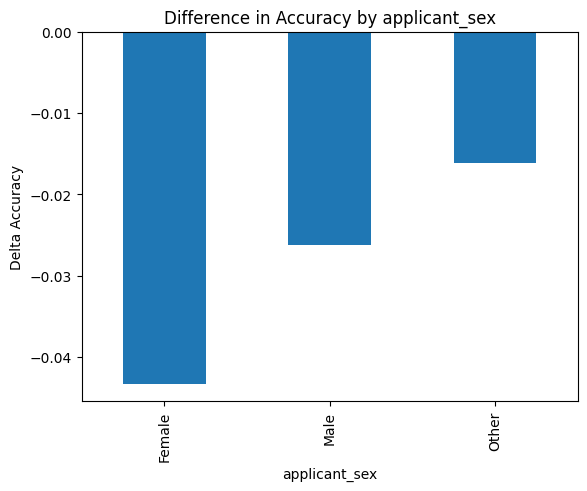

applicant_sex
Female   -0.043277
Male     -0.026240
Other    -0.016086
Name: accuracy_score, dtype: float64

In [25]:
# Testing the function. Note that it also returns a table for exact numbers. 
compare_models(y_test, y_pred, y_pred_original, sensitive_features_test['applicant_sex'], 'accuracy', 'Accuracy')

### Difference in metrics between original and mitigated models.

Analyzing Accuracy with respect to applicant_sex


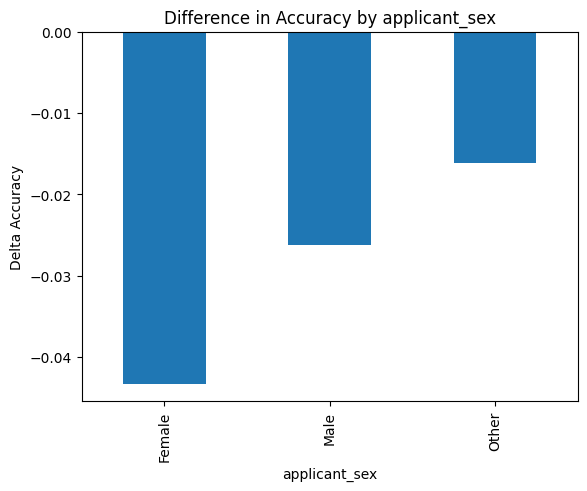

Analyzing Precision with respect to applicant_sex


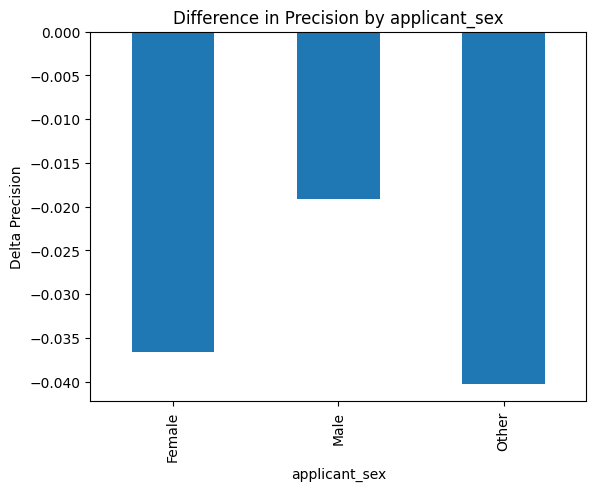

Analyzing Recall with respect to applicant_sex


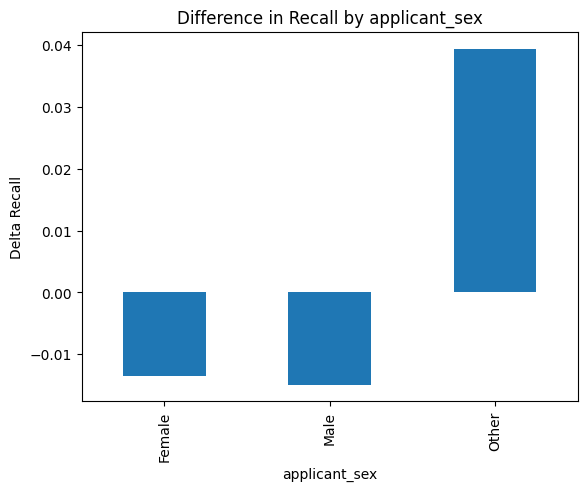

Analyzing F1 Score with respect to applicant_sex


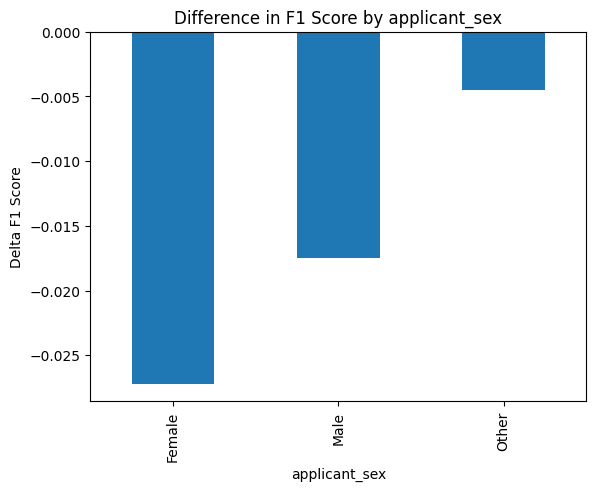

Analyzing False Positive Rate with respect to applicant_sex


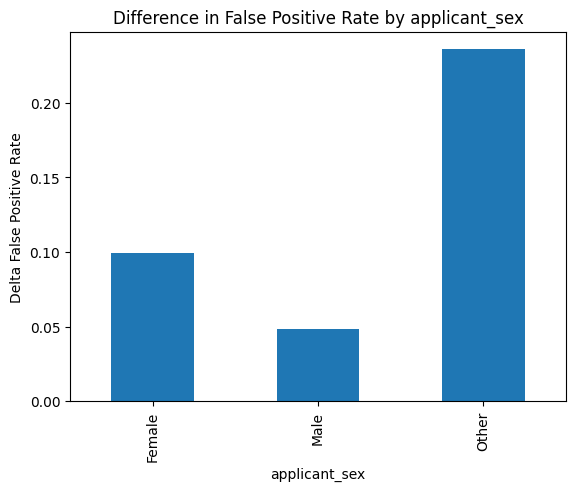

Analyzing False Negative Rate with respect to applicant_sex


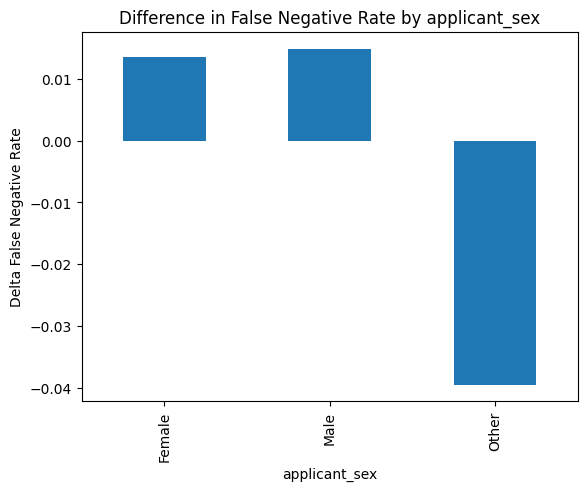

Analyzing Selection Rate with respect to applicant_sex


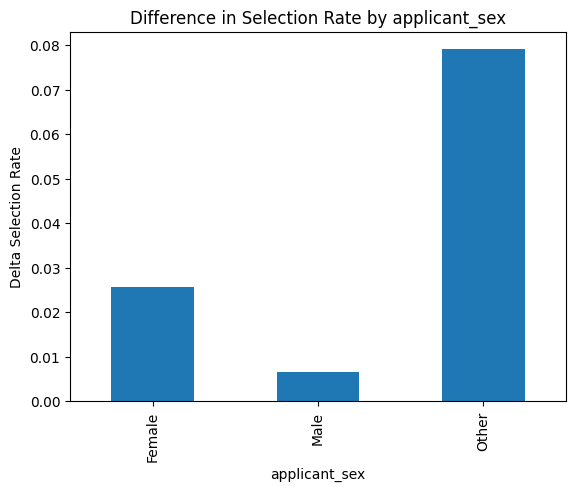

Analyzing Accuracy with respect to applicant_age_above_62


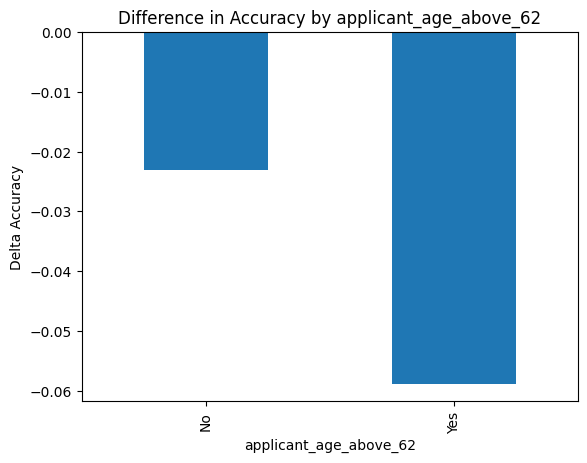

Analyzing Precision with respect to applicant_age_above_62


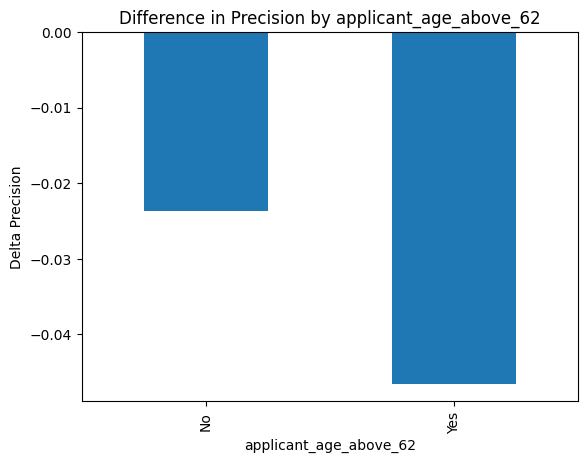

Analyzing Recall with respect to applicant_age_above_62


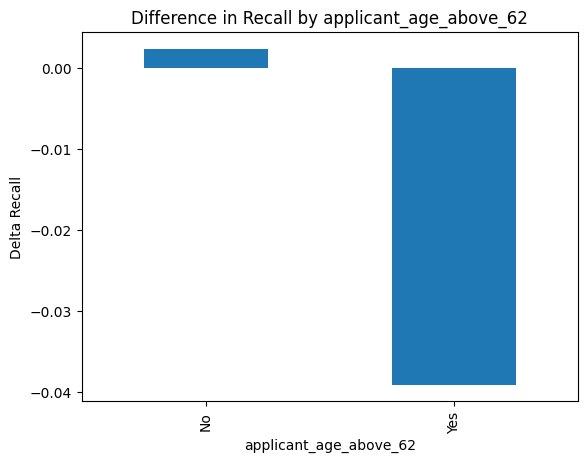

Analyzing F1 Score with respect to applicant_age_above_62


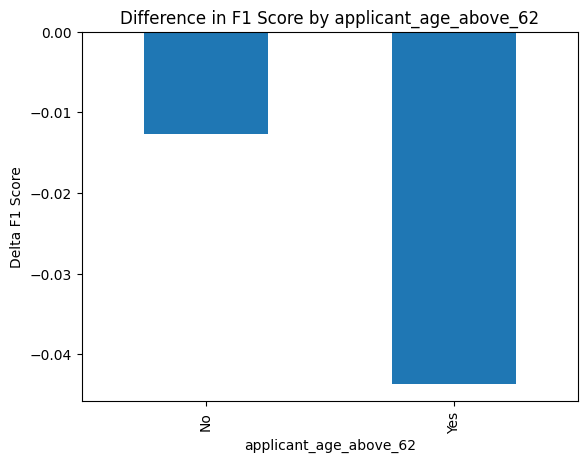

Analyzing False Positive Rate with respect to applicant_age_above_62


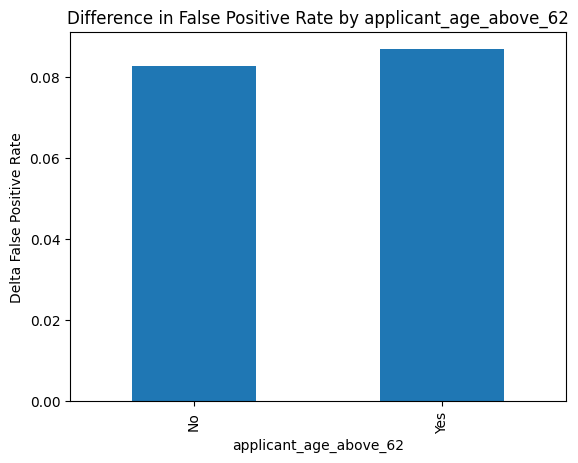

Analyzing False Negative Rate with respect to applicant_age_above_62


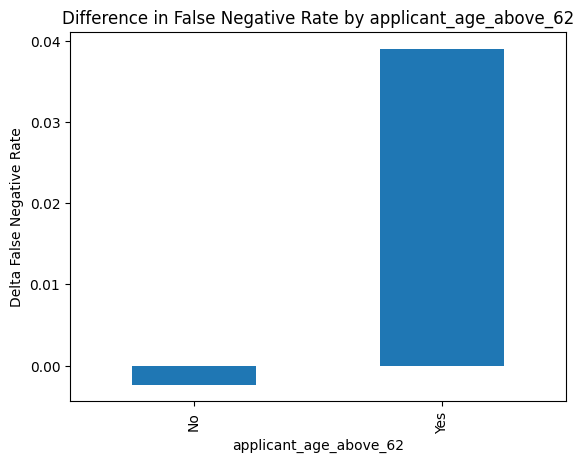

Analyzing Selection Rate with respect to applicant_age_above_62


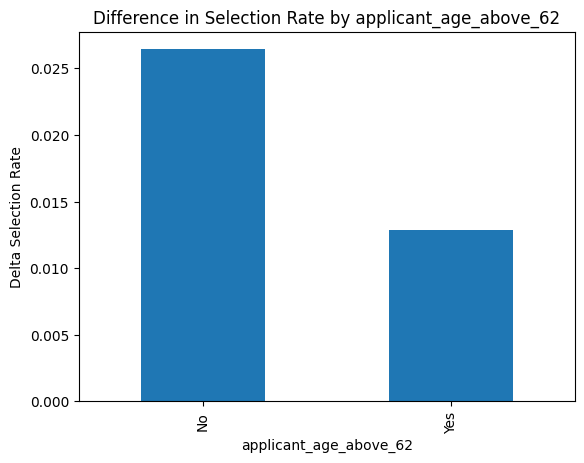

Analyzing Accuracy with respect to derived_race


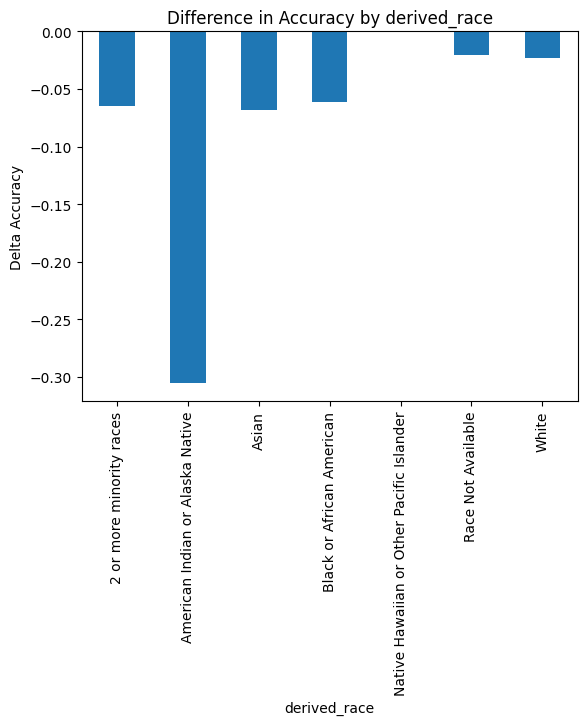

Analyzing Precision with respect to derived_race


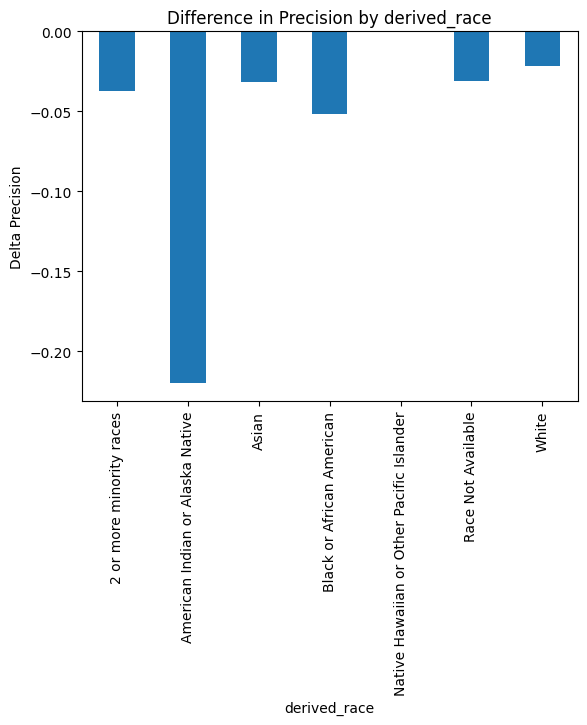

Analyzing Recall with respect to derived_race


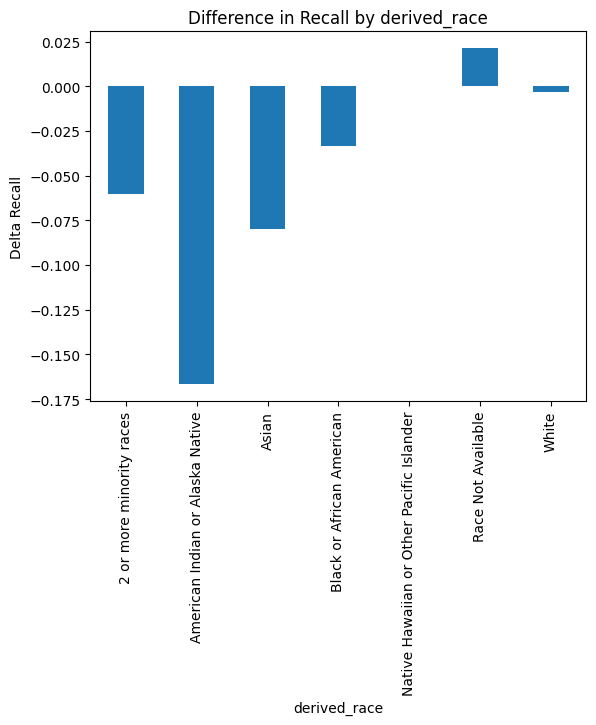

Analyzing F1 Score with respect to derived_race


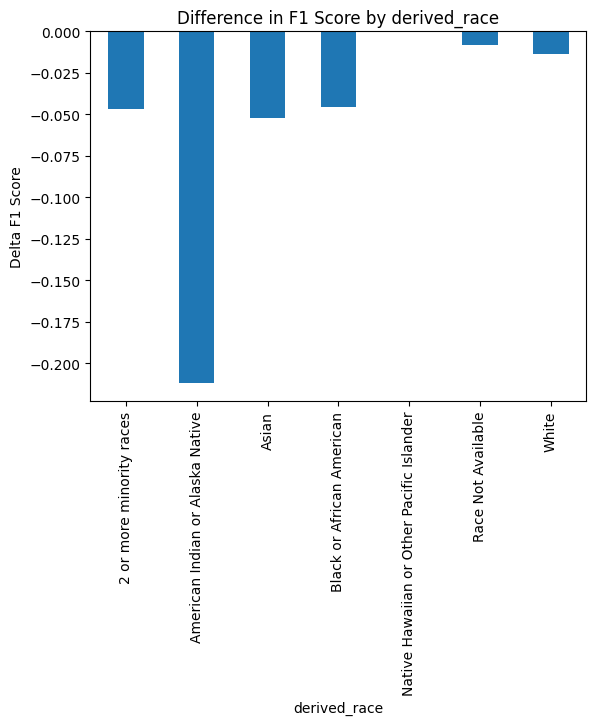

Analyzing False Positive Rate with respect to derived_race


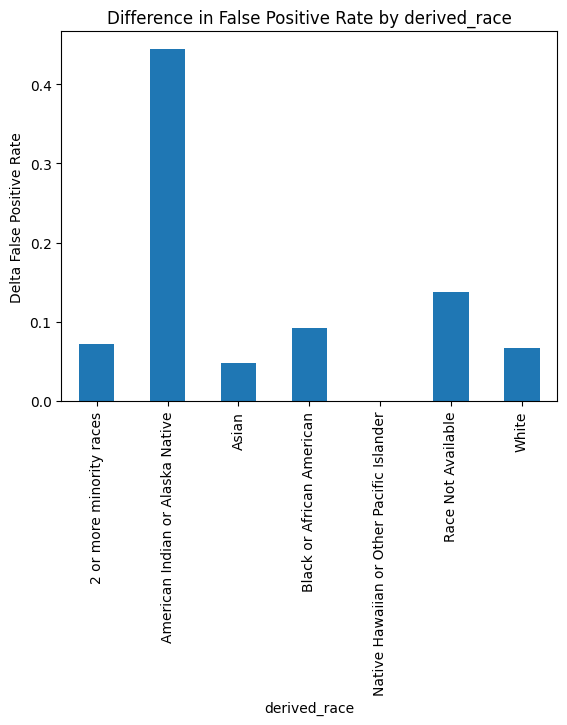

Analyzing False Negative Rate with respect to derived_race


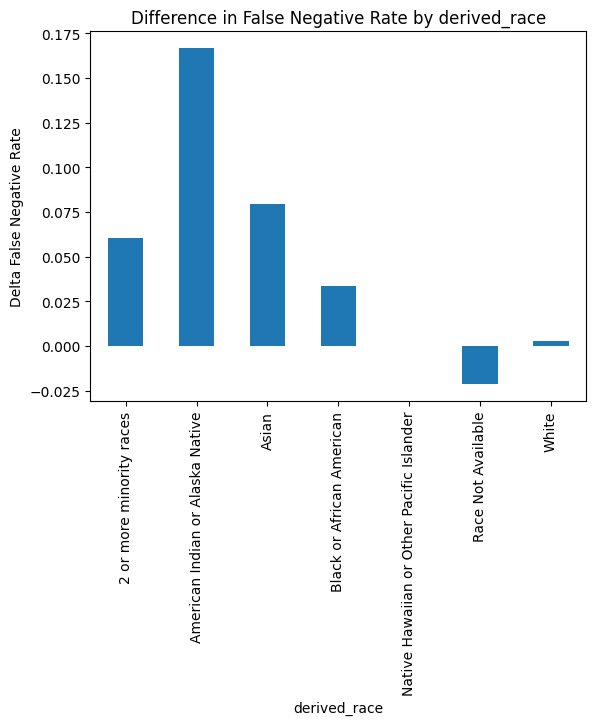

Analyzing Selection Rate with respect to derived_race


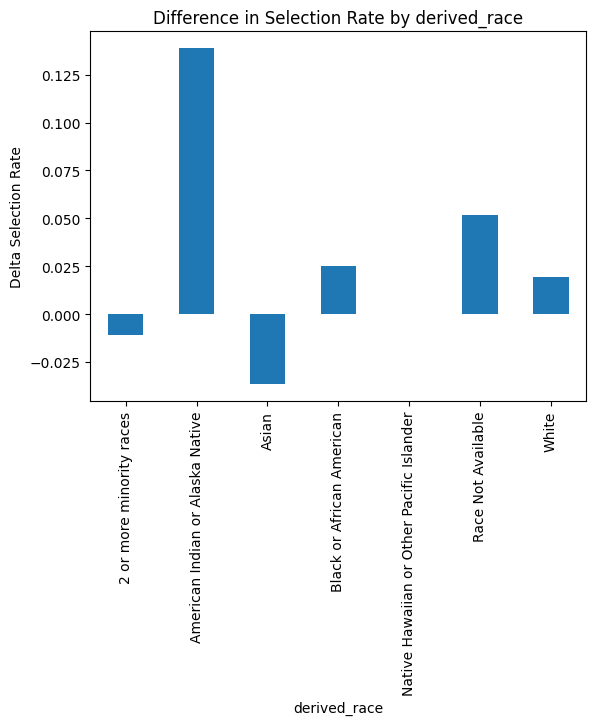

In [26]:
# List of metrics to compare
metrics_list = ['accuracy', 'precision', 'recall', 'F1 score', 'false positive rate', 'false negative rate', 'selection rate']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'Selection Rate']

# Looping through all features and metrics
for feature_name in sensitive_features_test.columns:
    for metric, metric_name in zip(metrics_list, metric_names):
        print(f"Analyzing {metric_name} with respect to {feature_name}")
        diff_df = compare_models(y_test, y_pred, y_pred_original, sensitive_features_test[feature_name], metric, metric_name)

        # Optional: Save or process diff_df here
        # e.g., diff_df.to_csv(f'{feature_name}_{metric}.csv')



### Now looking at percentage change in difference

In [27]:
def compare_models(y_test, y_pred, y_pred_original, sensitive_features, metric, metric_name):
    # Metrics dictionary
    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "F1 score": f1_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    }

    # Create MetricFrame for both predictions
    mf_original = MetricFrame(metrics=metrics[metric], y_true=y_test, y_pred=y_pred_original, sensitive_features=sensitive_features)
    mf_new = MetricFrame(metrics=metrics[metric], y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)

    # Calculate the percentage change
    diff = ((mf_new.by_group - mf_original.by_group) / mf_original.by_group) * 100

    # Handling division by zero or NaN values if any
    diff = diff.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Plotting the percentage change
    diff.plot(kind='bar', title=f"Percentage Change in {metric_name} by {sensitive_features.name}")
    plt.ylabel(f"% Change in {metric_name}")
    plt.show()

    return diff


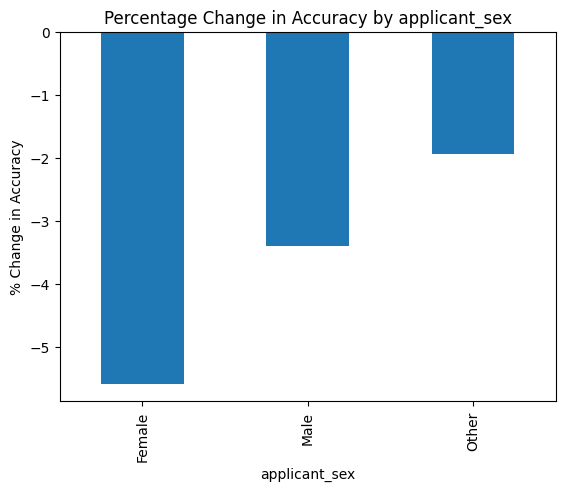

applicant_sex
Female   -5.582656
Male     -3.394325
Other    -1.943320
Name: accuracy_score, dtype: float64

In [28]:
# Testing the function. Note that it also returns a table for exact numbers. 
compare_models(y_test, y_pred, y_pred_original, sensitive_features_test['applicant_sex'], 'accuracy', 'Accuracy')

Analyzing Accuracy with respect to applicant_sex


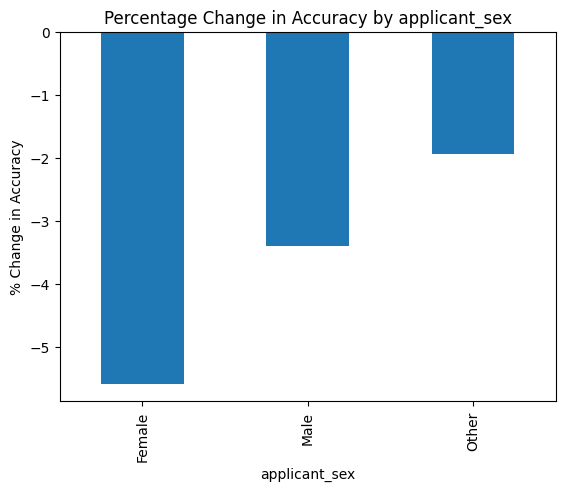

Analyzing Precision with respect to applicant_sex


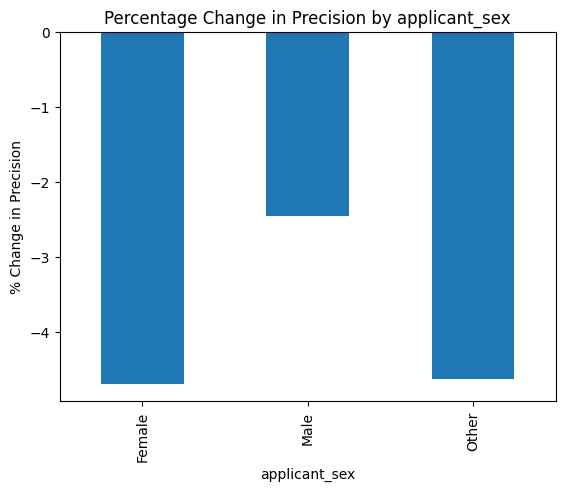

Analyzing Recall with respect to applicant_sex


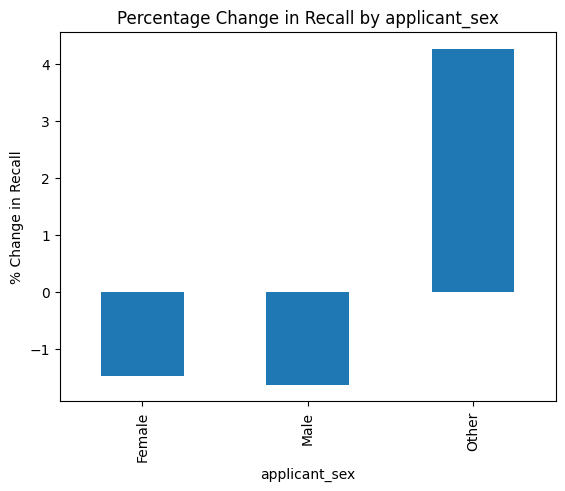

Analyzing F1 Score with respect to applicant_sex


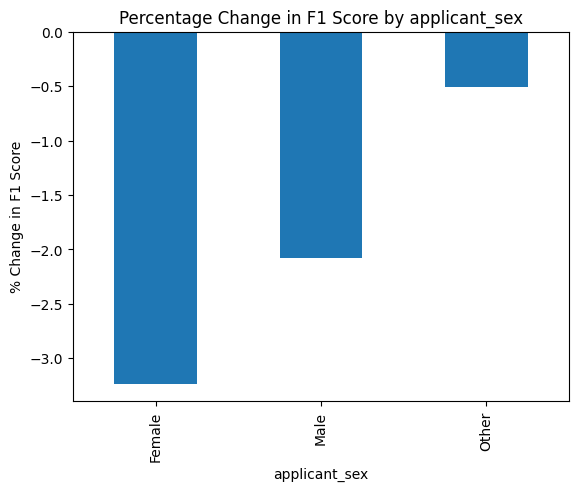

Analyzing False Positive Rate with respect to applicant_sex


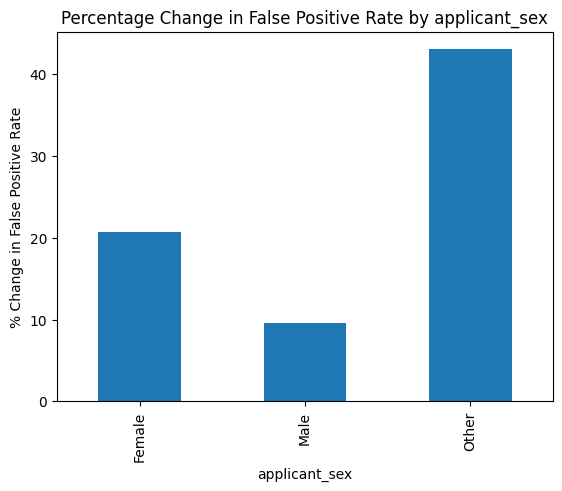

Analyzing False Negative Rate with respect to applicant_sex


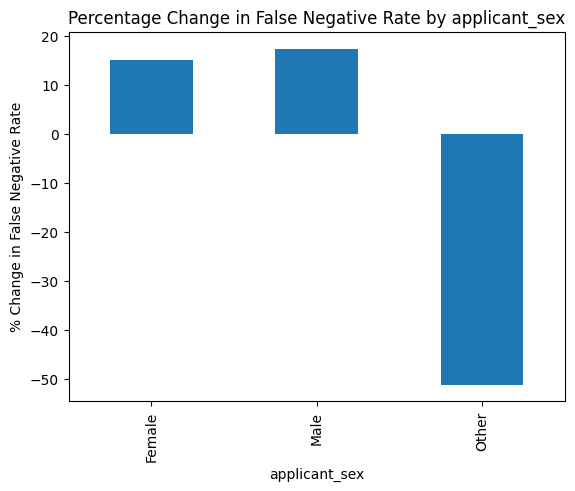

Analyzing Selection Rate with respect to applicant_sex


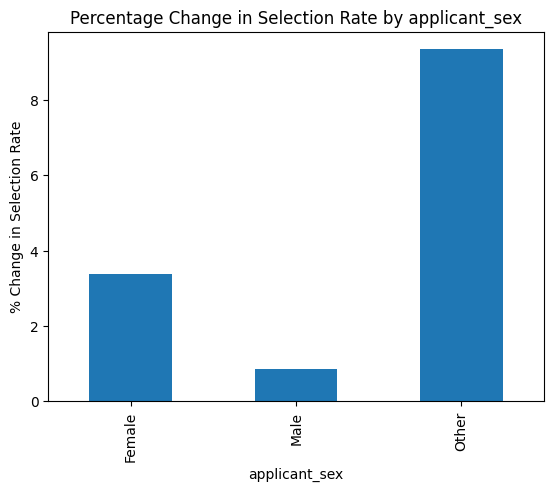

Analyzing Accuracy with respect to applicant_age_above_62


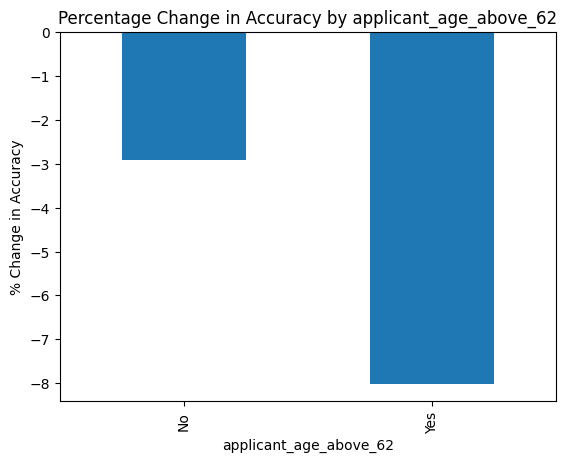

Analyzing Precision with respect to applicant_age_above_62


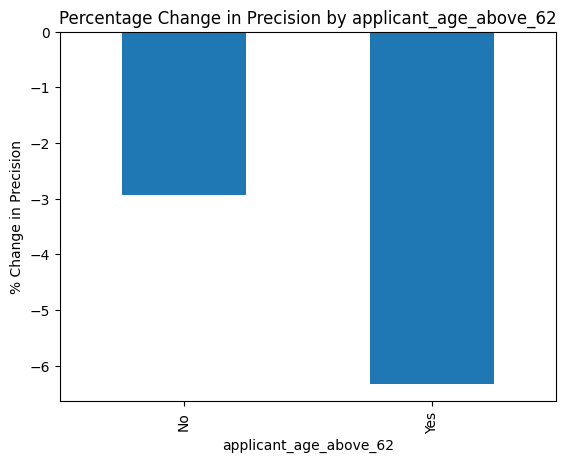

Analyzing Recall with respect to applicant_age_above_62


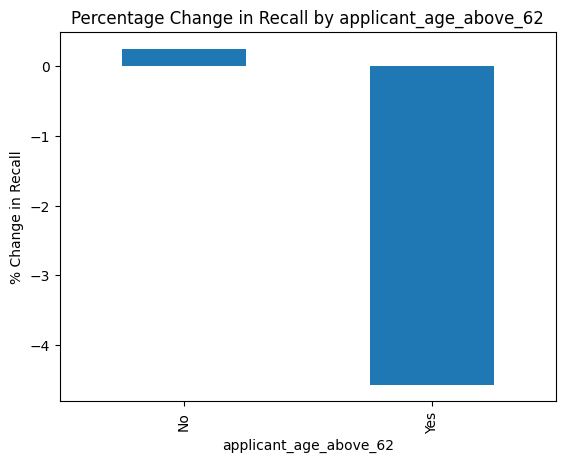

Analyzing F1 Score with respect to applicant_age_above_62


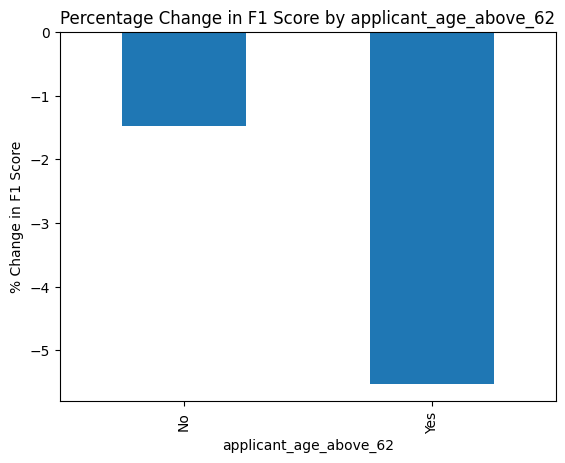

Analyzing False Positive Rate with respect to applicant_age_above_62


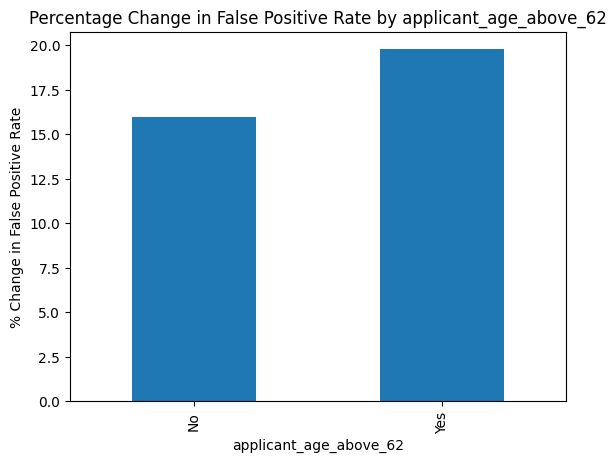

Analyzing False Negative Rate with respect to applicant_age_above_62


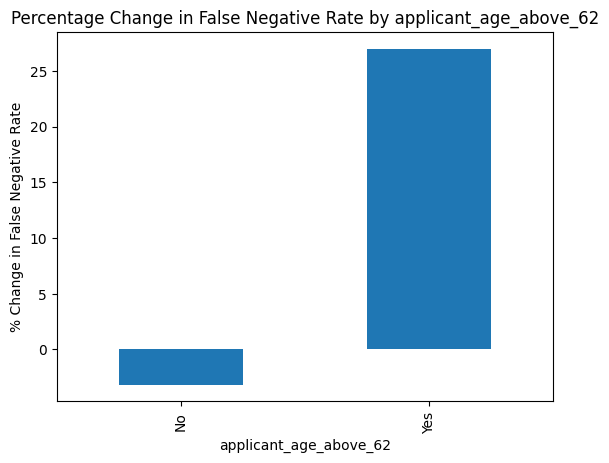

Analyzing Selection Rate with respect to applicant_age_above_62


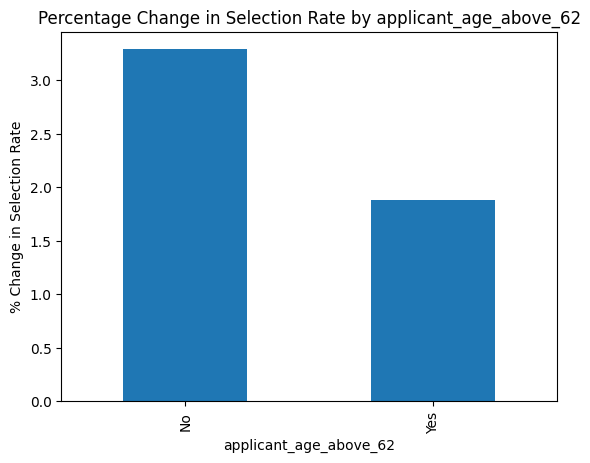

Analyzing Accuracy with respect to derived_race


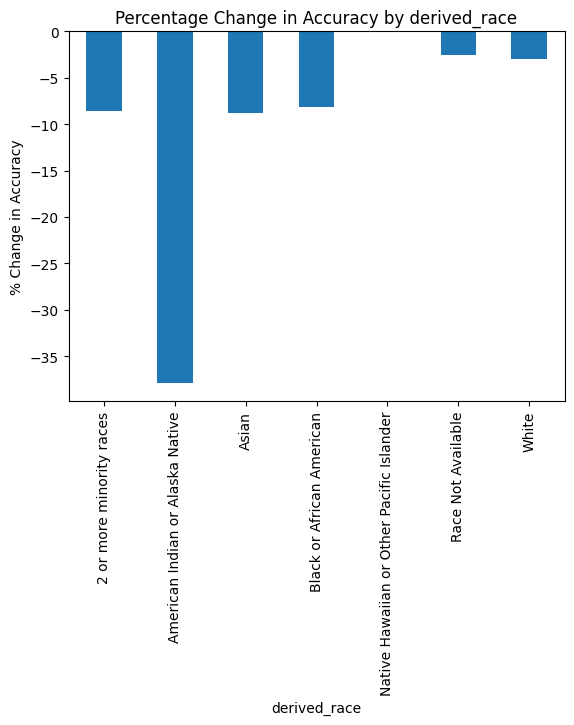

Analyzing Precision with respect to derived_race


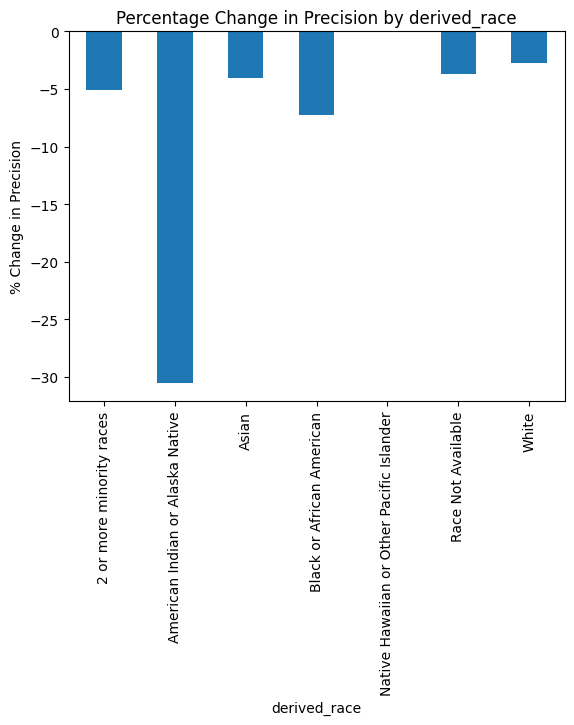

Analyzing Recall with respect to derived_race


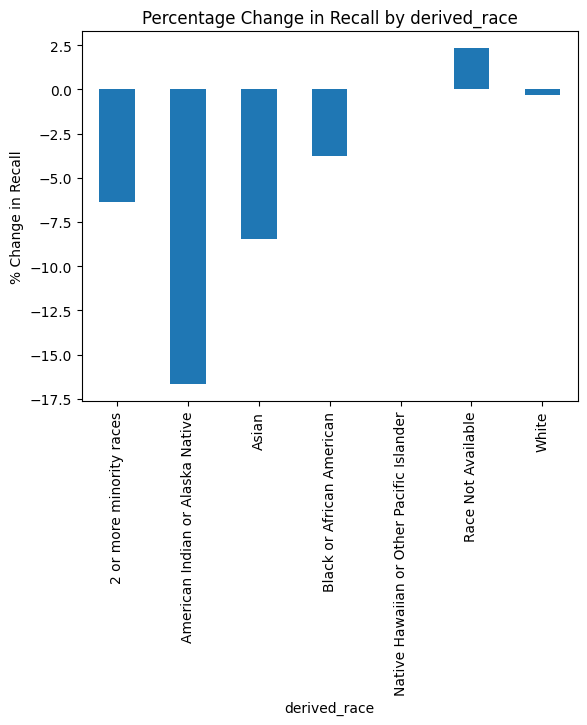

Analyzing F1 Score with respect to derived_race


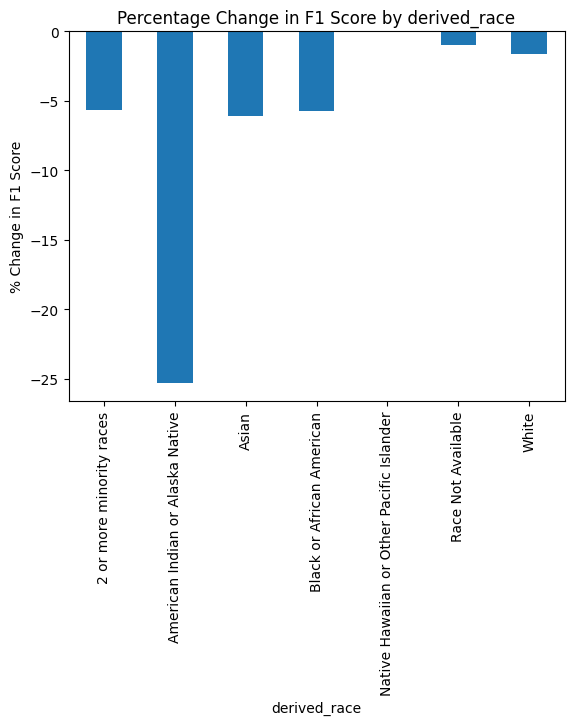

Analyzing False Positive Rate with respect to derived_race


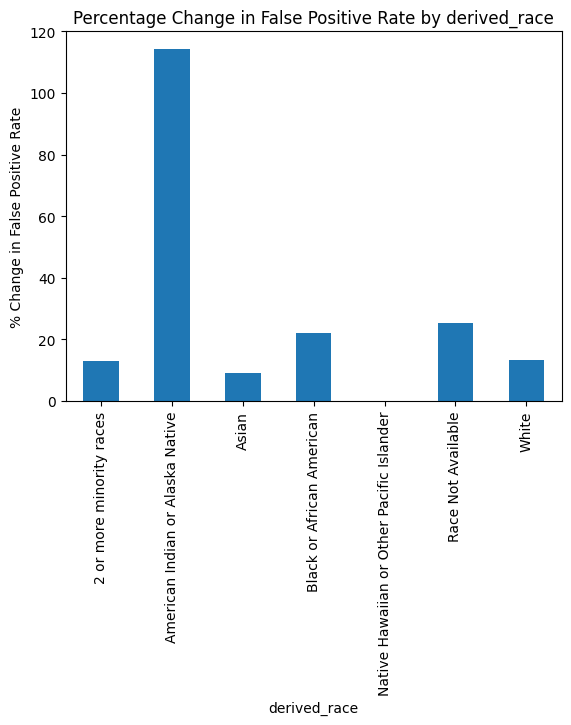

Analyzing False Negative Rate with respect to derived_race


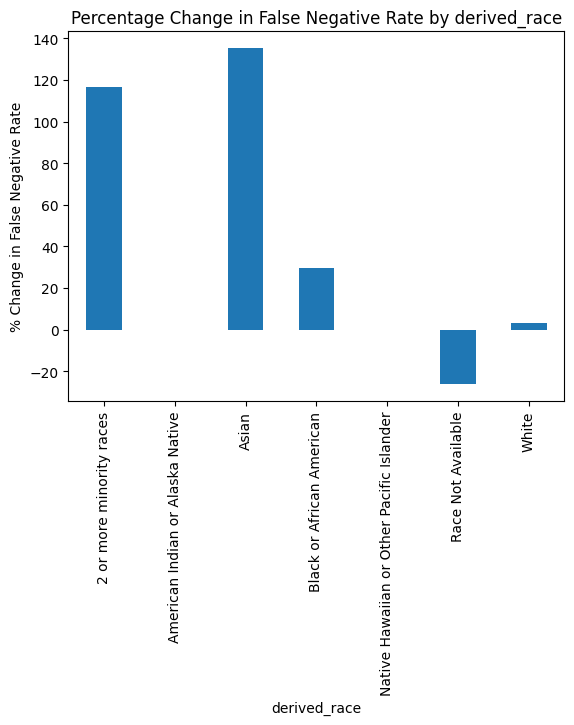

Analyzing Selection Rate with respect to derived_race


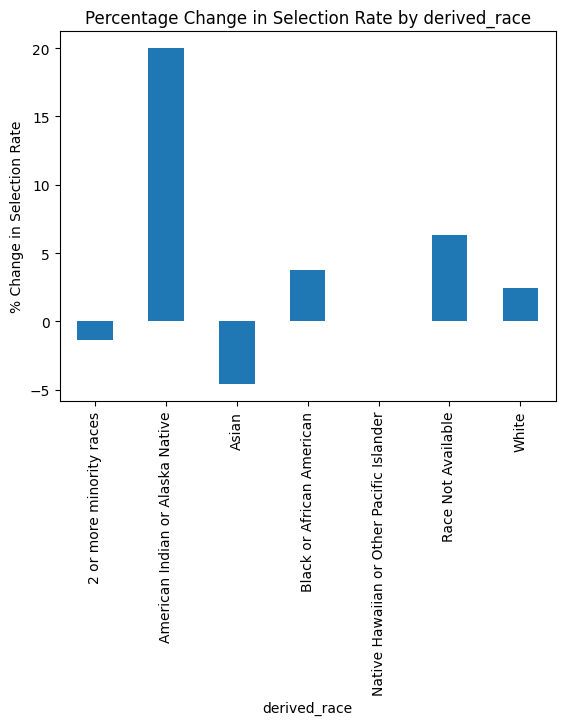

In [29]:
# List of metrics to compare
metrics_list = ['accuracy', 'precision', 'recall', 'F1 score', 'false positive rate', 'false negative rate', 'selection rate']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'Selection Rate']

# Looping through all features and metrics
for feature_name in sensitive_features_test.columns:
    for metric, metric_name in zip(metrics_list, metric_names):
        print(f"Analyzing {metric_name} with respect to {feature_name}")
        diff_df = compare_models(y_test, y_pred, y_pred_original, sensitive_features_test[feature_name], metric, metric_name)

        # Optional: Save or process diff_df here
        # e.g., diff_df.to_csv(f'{feature_name}_{metric}.csv')